# ECG analysis project
### Author: Marian Petruk


### Import libraries, modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import pandas as pd

from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
from utils import hamilton_detector, christov_detector, findpeaks, engzee_detector
from ecg_detectors.ecgdetectors import Detectors, MWA, panPeakDetect, searchBack

np.random.seed(256)
sns.set()
warnings.filterwarnings('ignore')

### Traverse data directory

In [2]:
import os

data_path = os.path.join("data", "Lviv-Biometric-Data-Set")
data_dirs = os.listdir(data_path)

data_dirs.remove("LICENSE")
data_dirs.remove("README.md")
print(len(data_dirs), "users = ", data_dirs)

USERID = 1
user_path = os.path.join(data_path, "user" + str(USERID))

user_ecg = os.listdir(user_path)
print("\nuser" + str(USERID), "has", len(user_ecg), "ecg samples =", user_ecg)

18 users =  ['user1', 'user10', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16', 'user17', 'user18', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9']

user1 has 7 ecg samples = ['user1_02_26_16_42.npy', 'user1_02_29_18_37.npy', 'user1_02_29_18_38.npy', 'user1_03_09_18_16.npy', 'user1_03_10_11_14.npy', 'user1_03_10_15_09.npy', 'user1_03_10_15_10.npy']


### Load raw ECG signal

In [3]:
import csv
from numpy import genfromtxt

#SAMPLE_FILE='sample2-external';
SAMPLE_FILE='sample1-default';

temp=pd.read_csv("samples/"+str(SAMPLE_FILE)+".csv")

data=np.empty([len(temp)])
for x in range(len(temp)):
    data[x]=temp.values[x][0]


### Plot raw ecg sample

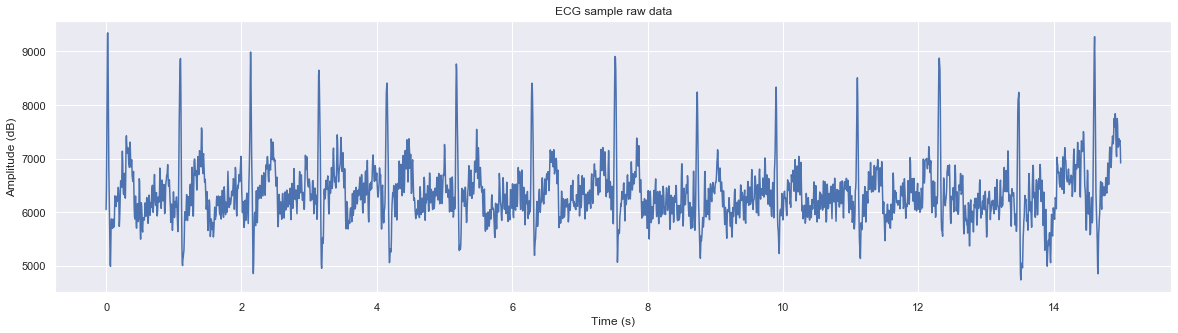

In [4]:
plt.figure(figsize=(20, 5))
plt.ylabel("Amplitude (dB)")
fs = 200
# Calculate time values in seconds
times = np.arange(data.shape[0], dtype='float') / fs
plt.plot(times, data)
plt.xlabel("Time (s)")
plt.title("ECG sample raw data")
plt.show()

### Filter the data from noice

#### **Butterworth Bandpass filter**

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,
                data)  # Filter data along one dimension using cascaded second-order sections. Using lfilter for each second-order section.
    return y


def butter_bandpass_filter_once(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    # Apply the filter to data. Use lfilter_zi to choose the initial condition of the filter.
    zi = sosfilt_zi(sos)
    z, _ = sosfilt(sos, data, zi=zi * data[0])
    return sos, z, zi


def butter_bandpass_filter_again(sos, z, zi):
    # Apply the filter again, to have a result filtered at an order the same as filtfilt.
    z2, _ = sosfilt(sos, z, zi=zi * z[0])
    return z2


def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,
                    data)  # Apply a digital filter forward and backward to a signal.This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.
    return y

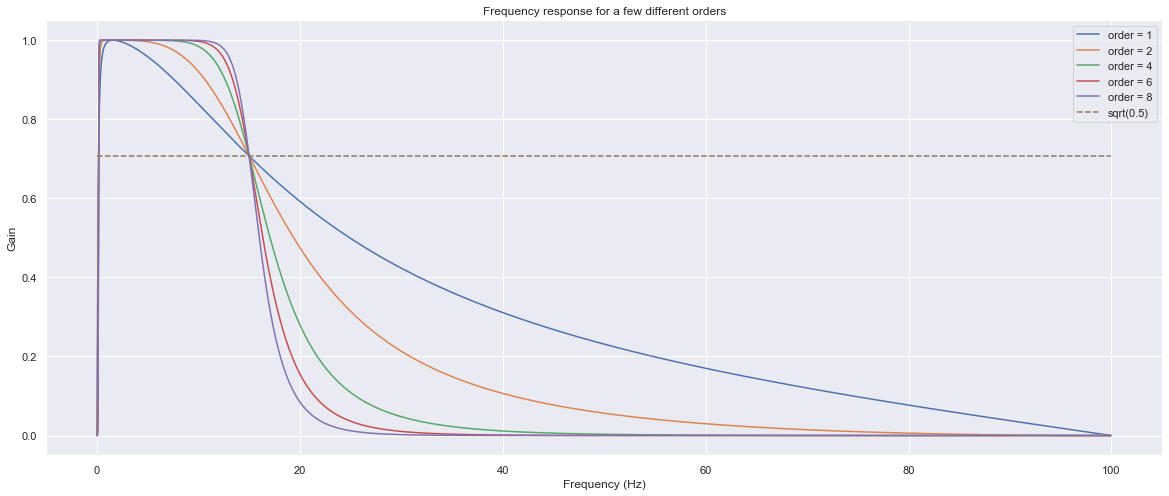

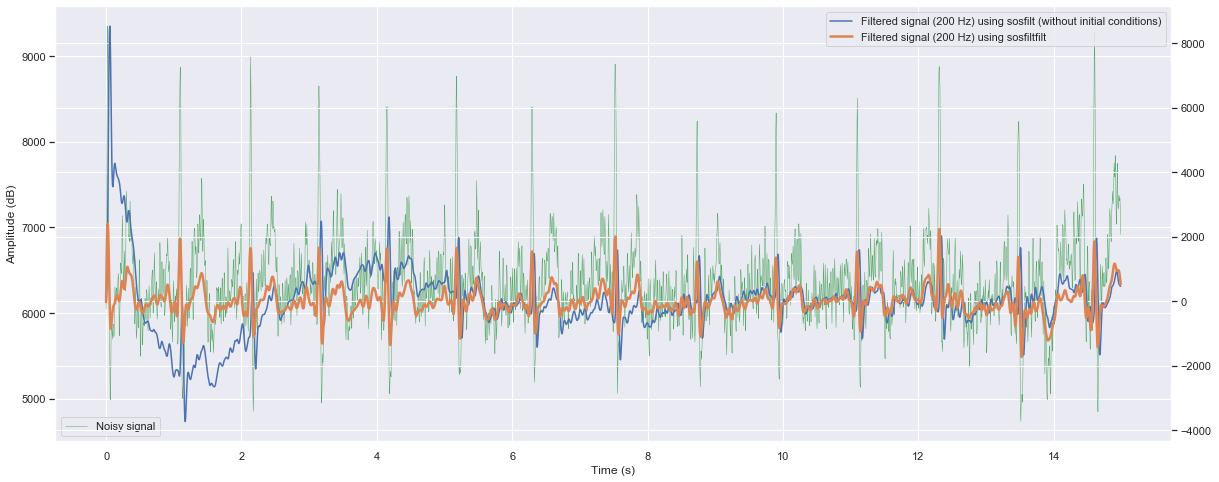

In [6]:
# Sample rate and desired cutoff frequencies (in Hz).
x = data
fs = 200  # corresponds to 60 beats per min (normal for human), assumed.
lowcut = 0.05 * 3.3  # 9.9 beats per min
highcut = 15  # 900 beats per min

# Plot the frequency response for a few different orders.
plt.figure(1, figsize=(20, 8))
plt.clf()
for order in [1, 2, 4, 6, 8]:
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         "--", label="sqrt(0.5)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.title("Frequency response for a few different orders")
plt.grid(True)
plt.legend(loc="best")

# Filter a noisy signal.


# Calculate time values in seconds
times = np.arange(x.shape[0], dtype='float') / fs

plt.figure(2, figsize=(20, 8))
plt.clf()
plt.ylabel("Amplitude (dB)")
plt.xlabel("Time (s)")
plt.plot(times, x, "g", linewidth=0.5, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times, butter_bandpass_filter(x, lowcut, highcut, fs, order=4),
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
y = butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4)
plt.plot(times, y, linewidth=2.5, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)

# plt.twiny()
# plt.plot(butter_bandpass_forward_backward_filter(data, 0.05, 15, 250, order=4), linewidth=2, label="Filtered signal (%g Hz) using sosfiltfilt" % fs)


plt.grid(True)
plt.axis("tight")
plt.legend(loc="upper right")

plt.show()

As we can see, it is better to use `scipy.signal.sosfiltfilt` instead of `sosfilt` to apply the Butterworth filter. `sosfiltfilt` is the forward-backward filter. It applies the filter twice, once forward and once backward, resulting in zero phase delay.

#### Illustration of a phase delay/shift

Phase shift is any change that occurs in the phase of one quantity, or in the phase difference between two or more quantities. (c) Wikipedia 
<img width="300px" src="images/Phase_shift.png" alt="illustration of phase shift from wikipedia">

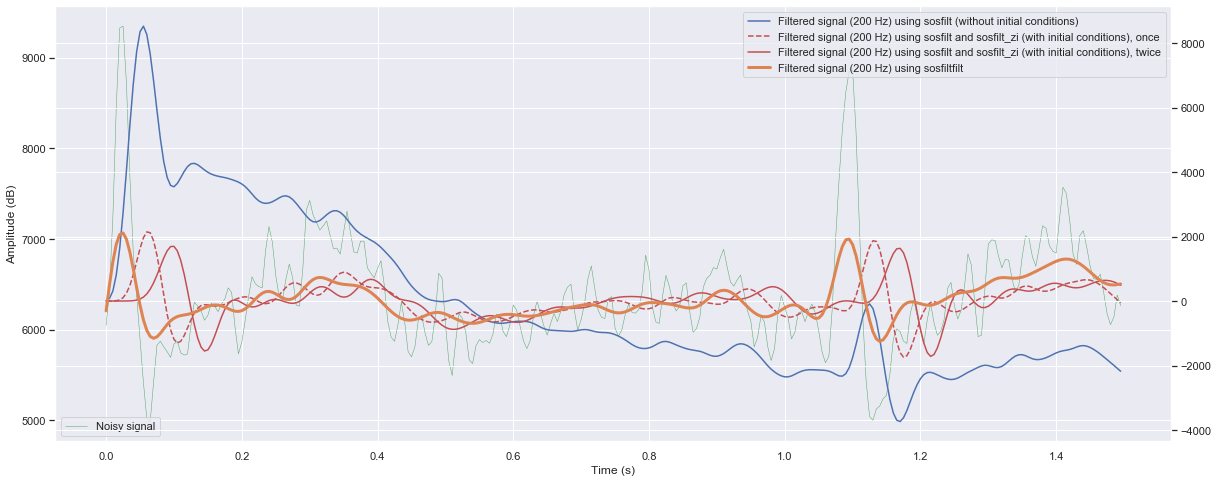

In [7]:
x = data[:300]
plt.figure(figsize=(20, 8))

plt.ylabel("Amplitude (dB)")
# Calculate time values in seconds
times = np.arange(x.shape[0], dtype='float') / fs
plt.xlabel("Time (s)")

plt.plot(times, x, "g", linewidth=0.5, label="Noisy signal")
plt.legend(loc="lower left")
plt.twinx()
plt.plot(times, butter_bandpass_filter(x, lowcut, highcut, fs, order=4),
         label="Filtered signal (%g Hz) using sosfilt (without initial conditions)" % fs)
sos, z, zi = butter_bandpass_filter_once(x, lowcut, highcut, fs, order=5)
plt.plot(times, z, "r--", label="Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), once" % fs)
plt.plot(times, butter_bandpass_filter_again(sos, z, zi), "r",
         label="Filtered signal (%g Hz) using sosfilt and sosfilt_zi (with initial conditions), twice" % fs)
plt.plot(times, butter_bandpass_forward_backward_filter(x, lowcut, highcut, fs, order=4), linewidth=3,
         label="Filtered signal (%g Hz) using sosfiltfilt" % fs)
plt.grid(True)
plt.axis("tight")
plt.legend(loc="upper right")

plt.show()

We can see phase delay on filtered singal using `sosfilt` without initial conditions and on both stages of `sosfilt` with initial conditions (`sosfilt_zi`). However, `sosfiltfilt` - a forward-backward digital filter has **zero phase delay/shift**.

## QRS

QRS detection is difficult, not only because of the physiological variability of the QRS complexes, but also because of the various types of noise that can be present in the ECG signal. Noise sources include muscle noise, artifacts due to electrode motion, power-line interference, baseline wander and T waves with high frequency characteristics similar to QRS complexes.

### Detect R-peaks

#### Main detector that is used is pan-tompkins

In [8]:
def pan_tompkins_detector(raw_ecg, mwa, fs, N):
   
#     N = int(0.12 * fs)
#     mwa = MWA(squared, N)
#     mwa[:int(0.2 * fs)] = 0

    N = int(N / 100 * fs)
    mwa_peaks = panPeakDetect(mwa, fs)

    r_peaks = searchBack(mwa_peaks, raw_ecg, N)

    return r_peaks


In [9]:
# Derivative - provides QRS slope information.
differentiated_ecg_measurements = np.ediff1d(y)

# Squaring - intensifies values received in derivative. 
# This helps restrict false positives caused by T waves with higher than usual spectral energies..
squared_ecg_measurements = differentiated_ecg_measurements ** 2

# Moving-window integration.
integration_window = 50  # Change proportionally when adjusting frequency (in samples)
integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

# Fiducial mark - peak detection on integrated measurements.
rpeaks = pan_tompkins_detector(data, integrated_ecg_measurements, fs, integration_window)
print(rpeaks)



[   5  220  427  629  830 1035 1259 1504 1747 1980 2220 2462 2697 2921]


### RR-intervals (aka NN-intervals)

The term **`NN`** is used in place of **RR** to emphasize the fact that the processed beats are "normal" beats. (с) Wikipedia

Heart rate variability (HRV) is the physiological phenomenon of variation in the time interval between heartbeats. It is measured by the variation in the beat-to-beat interval.

In [10]:
rr = np.diff(rpeaks) / fs * 1000  # in miliseconds
hr = 60 * 1000 / rr
print("rr =", rr)
print("hr =", hr)
rr

rr = [1075. 1035. 1010. 1005. 1025. 1120. 1225. 1215. 1165. 1200. 1210. 1175.
 1120.]
hr = [55.81395349 57.97101449 59.40594059 59.70149254 58.53658537 53.57142857
 48.97959184 49.38271605 51.50214592 50.         49.58677686 51.06382979
 53.57142857]


array([1075., 1035., 1010., 1005., 1025., 1120., 1225., 1215., 1165.,
       1200., 1210., 1175., 1120.])

### HRV features
#### Time-domain methods

In [11]:

import pyhrv.tools as tools
from biosppy import utils

def timeDomain(NN):
    
    L = len(NN)    
    ANN = np.mean(NN)
    SDNN = np.std(NN)
    SDSD = np.std(np.diff(NN))    
    NN50 = len(np.where(np.diff(NN) > 0.05)[0])    
    pNN50 = NN50/L    
    NN20 = len(np.where(np.diff(NN) > 0.02)[0])
    pNN20 = NN20/L
    rMSSD = np.sqrt((1/L) * sum(np.diff(NN) ** 2))        
    MedianNN = np.median(NN)
    SDANN = sdann(rr)['sdann']
    SDNN_INDEX=sdnn_index(rr)['sdnn_index']
    
    timeDomainFeats = {
        "ANN": ANN, "SDNN": SDNN,
        "SDSD": SDSD, "NN50": NN50,
                       "SDANN":SDANN , "SDNN_INDEX": SDNN_INDEX,
                       "pNN50": pNN50, "NN20": NN20,
                       "pNN20": pNN20, "rMSSD": rMSSD,
                       "MedianNN":MedianNN}
                       
    return timeDomainFeats


def sdnn_index(nni=None, rpeaks=None, full=True, overlap=False, duration=300):

    # Check input
    nn = tools.check_input(nni, rpeaks)

    # Signal segmentation into 5 min segments
    segments, seg = tools.segmentation(nn,  full=full, overlap=overlap, duration=duration)

    if seg:
        sdnn_values = [sdnn(x)['sdnn'] for x in segments]
        sdnn_index = np.mean(sdnn_values)
    else:
        sdnn_index = float('nan')
        if tools.WARN:
            warnings.warn("Signal duration too short for SDNN index computation.")

    # Output
    args = [sdnn_index]
    names = ['sdnn_index']
    return utils.ReturnTuple(args, names)


def sdann(nni=None, rpeaks=None, full=True, overlap=False, duration=300):

    # Check input
    nn = tools.check_input(nni, rpeaks)

    # Signal segmentation into 5 min segments
    segments, seg = tools.segmentation(nn, full=full, overlap=overlap, duration=duration)

    if seg:
        mean_values = [np.mean(x) for x in segments]
        sdann_ = tools.std(mean_values)
    else:
        sdann_ = float('nan')
        if tools.WARN:
            warnings.warn("Signal duration too short for SDANN computation.")

    # Output
    args = [sdann_]
    names = ['sdann']
    return utils.ReturnTuple(args, names)

In [12]:

result = timeDomain(rr)
timeDomain(rr)

resultJSON=(str(result).replace("'",'"')).replace('nan','"nan"')

f = open("samples/"+SAMPLE_FILE+"-result.json", "w")
f.write(resultJSON)
f.close()